## Imports

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, mean_squared_error, accuracy_score
import seaborn as sns
import datetime as dt
from scipy import stats
from scipy.stats import norm
import lightgbm as lgbm
pd.options.display.float_format = '{:.0f}'.format

## Loading Dataset

In [4]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("DelayedFlights.csv")
df.drop(columns = ['Unnamed: 0', 'Year', 'FlightNum'], inplace = True)
df

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1,3,4,2003,1955,2211,2225,WN,N712SW,128,150,116,-14,8,IAD,TPA,810,4,8,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,3,4,754,735,1002,1000,WN,N772SW,128,145,113,2,19,IAD,TPA,810,5,10,0,N,0,NaN,NaN,NaN,NaN,NaN
2,1,3,4,628,620,804,750,WN,N428WN,96,90,76,14,8,IND,BWI,515,3,17,0,N,0,NaN,NaN,NaN,NaN,NaN
3,1,3,4,1829,1755,1959,1925,WN,N464WN,90,90,77,34,34,IND,BWI,515,3,10,0,N,0,2,0,0,0,32
4,1,3,4,1940,1915,2121,2110,WN,N726SW,101,115,87,11,25,IND,JAX,688,4,10,0,N,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936753,12,13,6,1250,1220,1617,1552,DL,N938DL,147,152,120,25,30,MSP,ATL,906,9,18,0,N,0,3,0,0,0,22
1936754,12,13,6,657,600,904,749,DL,N3743H,127,109,78,75,57,RIC,ATL,481,15,34,0,N,0,0,57,18,0,0
1936755,12,13,6,1007,847,1149,1010,DL,N909DA,162,143,122,99,80,ATL,IAH,689,8,32,0,N,0,1,0,19,0,79
1936756,12,13,6,1251,1240,1446,1437,DL,N646DL,115,117,89,9,11,IAD,ATL,533,13,13,0,N,0,NaN,NaN,NaN,NaN,NaN


array([[<AxesSubplot:title={'center':'DepDelay'}>]], dtype=object)

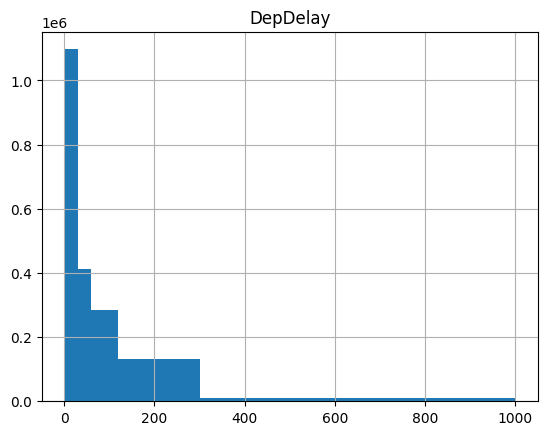

In [3]:
df.hist(column = 'DepDelay', bins = [0, 30, 60, 120, 300, 1000])

In [5]:
def create_categories(minutes):
    if minutes <= 30:
        return 0
    elif minutes > 30 and minutes <= 60:
        return 1
    elif minutes > 60 and minutes <= 120:
        return 2
    elif minutes > 120 and minutes <= 180:
        return 3
    elif minutes > 180 and minutes <= 300:
        return 4
    else:
        return 5


In [6]:
df['DelayCategory'] = df['DepDelay'].apply(create_categories)
df

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DelayCategory
0,1,3,4,2003,1955,2211,2225,WN,N712SW,128,150,116,-14,8,IAD,TPA,810,4,8,0,N,0,NaN,NaN,NaN,NaN,NaN,0
1,1,3,4,754,735,1002,1000,WN,N772SW,128,145,113,2,19,IAD,TPA,810,5,10,0,N,0,NaN,NaN,NaN,NaN,NaN,0
2,1,3,4,628,620,804,750,WN,N428WN,96,90,76,14,8,IND,BWI,515,3,17,0,N,0,NaN,NaN,NaN,NaN,NaN,0
3,1,3,4,1829,1755,1959,1925,WN,N464WN,90,90,77,34,34,IND,BWI,515,3,10,0,N,0,2,0,0,0,32,1
4,1,3,4,1940,1915,2121,2110,WN,N726SW,101,115,87,11,25,IND,JAX,688,4,10,0,N,0,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936753,12,13,6,1250,1220,1617,1552,DL,N938DL,147,152,120,25,30,MSP,ATL,906,9,18,0,N,0,3,0,0,0,22,0
1936754,12,13,6,657,600,904,749,DL,N3743H,127,109,78,75,57,RIC,ATL,481,15,34,0,N,0,0,57,18,0,0,1
1936755,12,13,6,1007,847,1149,1010,DL,N909DA,162,143,122,99,80,ATL,IAH,689,8,32,0,N,0,1,0,19,0,79,2
1936756,12,13,6,1251,1240,1446,1437,DL,N646DL,115,117,89,9,11,IAD,ATL,533,13,13,0,N,0,NaN,NaN,NaN,NaN,NaN,0


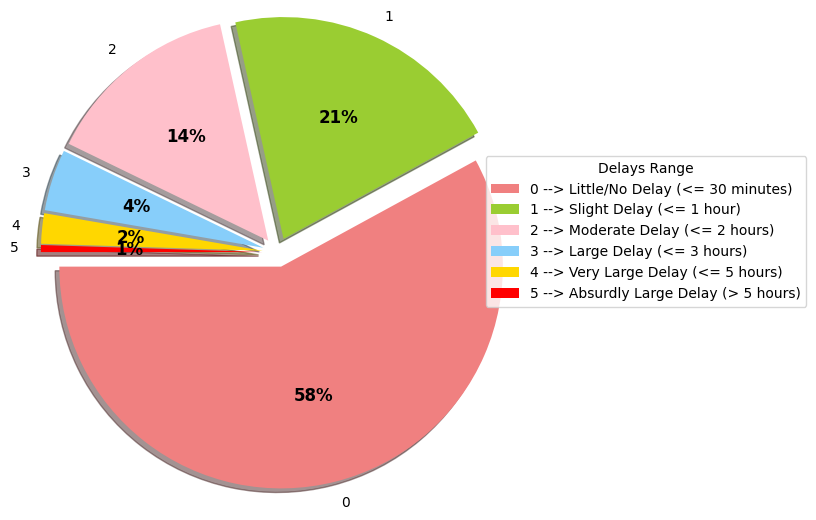

In [24]:
unique, count = np.unique(df["DelayCategory"].values, return_counts=True)

color = ['lightcoral', 'yellowgreen', 'pink', 'lightskyblue', 'gold', 'red']

_, _, texts = plt.pie(count, labels=unique.astype('int8'), radius = 1.5, autopct = '%.f%%',
        shadow=True, explode=[0.1, 0.1 ,0.1, 0.1, 0.1, 0.1], startangle=180, colors = color
        )

legend_label = ["0 --> Little/No Delay (<= 30 minutes)" , "1 --> Slight Delay (<= 1 hour)", "2 --> Moderate Delay (<= 2 hours)",
                "3 --> Large Delay (<= 3 hours)", "4 --> Very Large Delay (<= 5 hours)", "5 --> Absurdly Large Delay (> 5 hours)"]

plt.setp(texts, size = 12, weight ="bold")
plt.legend(legend_label, title = "Delays Range",loc = 'upper right', bbox_to_anchor=(1.45, 0.28, 0.5, 0.5))
plt.show()

In [25]:
def create_categories(minutes):
    if minutes <= 30:
        return 0
    elif minutes > 30 and minutes <= 60:
        return 1
    elif minutes > 60 and minutes <= 120:
        return 2
    elif minutes > 120 and minutes <= 180:
        return 3
    else:
        return 4

In [26]:
df['DelayCategory'] = df['DepDelay'].apply(create_categories)
df

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DelayCategory
0,1,3,4,2003,1955,2211,2225,WN,N712SW,128,150,116,-14,8,IAD,TPA,810,4,8,0,N,0,NaN,NaN,NaN,NaN,NaN,0
1,1,3,4,754,735,1002,1000,WN,N772SW,128,145,113,2,19,IAD,TPA,810,5,10,0,N,0,NaN,NaN,NaN,NaN,NaN,0
2,1,3,4,628,620,804,750,WN,N428WN,96,90,76,14,8,IND,BWI,515,3,17,0,N,0,NaN,NaN,NaN,NaN,NaN,0
3,1,3,4,1829,1755,1959,1925,WN,N464WN,90,90,77,34,34,IND,BWI,515,3,10,0,N,0,2,0,0,0,32,1
4,1,3,4,1940,1915,2121,2110,WN,N726SW,101,115,87,11,25,IND,JAX,688,4,10,0,N,0,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936753,12,13,6,1250,1220,1617,1552,DL,N938DL,147,152,120,25,30,MSP,ATL,906,9,18,0,N,0,3,0,0,0,22,0
1936754,12,13,6,657,600,904,749,DL,N3743H,127,109,78,75,57,RIC,ATL,481,15,34,0,N,0,0,57,18,0,0,1
1936755,12,13,6,1007,847,1149,1010,DL,N909DA,162,143,122,99,80,ATL,IAH,689,8,32,0,N,0,1,0,19,0,79,2
1936756,12,13,6,1251,1240,1446,1437,DL,N646DL,115,117,89,9,11,IAD,ATL,533,13,13,0,N,0,NaN,NaN,NaN,NaN,NaN,0


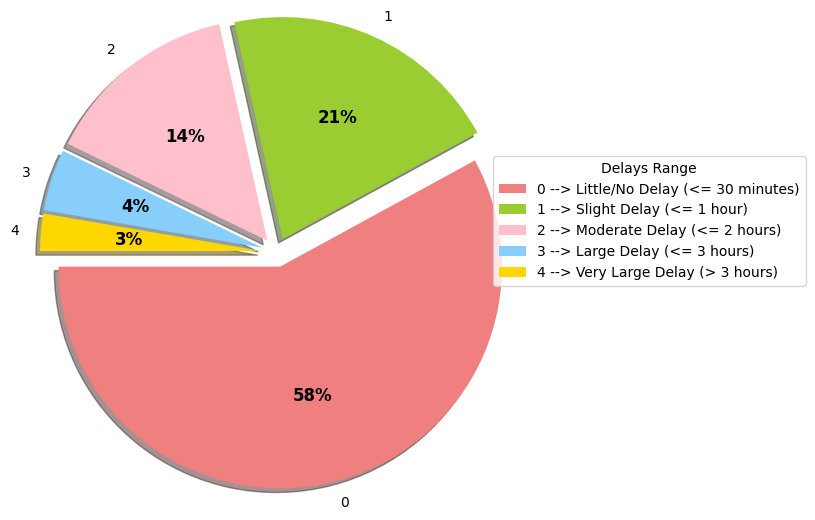

In [27]:
unique, count = np.unique(df["DelayCategory"].values, return_counts=True)

color = ['lightcoral', 'yellowgreen', 'pink', 'lightskyblue', 'gold']

_, _, texts = plt.pie(count, labels=unique.astype('int8'), radius = 1.5, autopct = '%.f%%',
        shadow=True, explode=[0.1, 0.1 ,0.1, 0.1, 0.1], startangle=180, colors = color
        )

legend_label = ["0 --> Little/No Delay (<= 30 minutes)" , "1 --> Slight Delay (<= 1 hour)", "2 --> Moderate Delay (<= 2 hours)",
                "3 --> Large Delay (<= 3 hours)", "4 --> Very Large Delay (> 3 hours)"]

plt.setp(texts, size = 12, weight ="bold")
plt.legend(legend_label, title = "Delays Range",loc = 'upper right', bbox_to_anchor=(1.45, 0.28, 0.5, 0.5))
plt.show()

<AxesSubplot:>

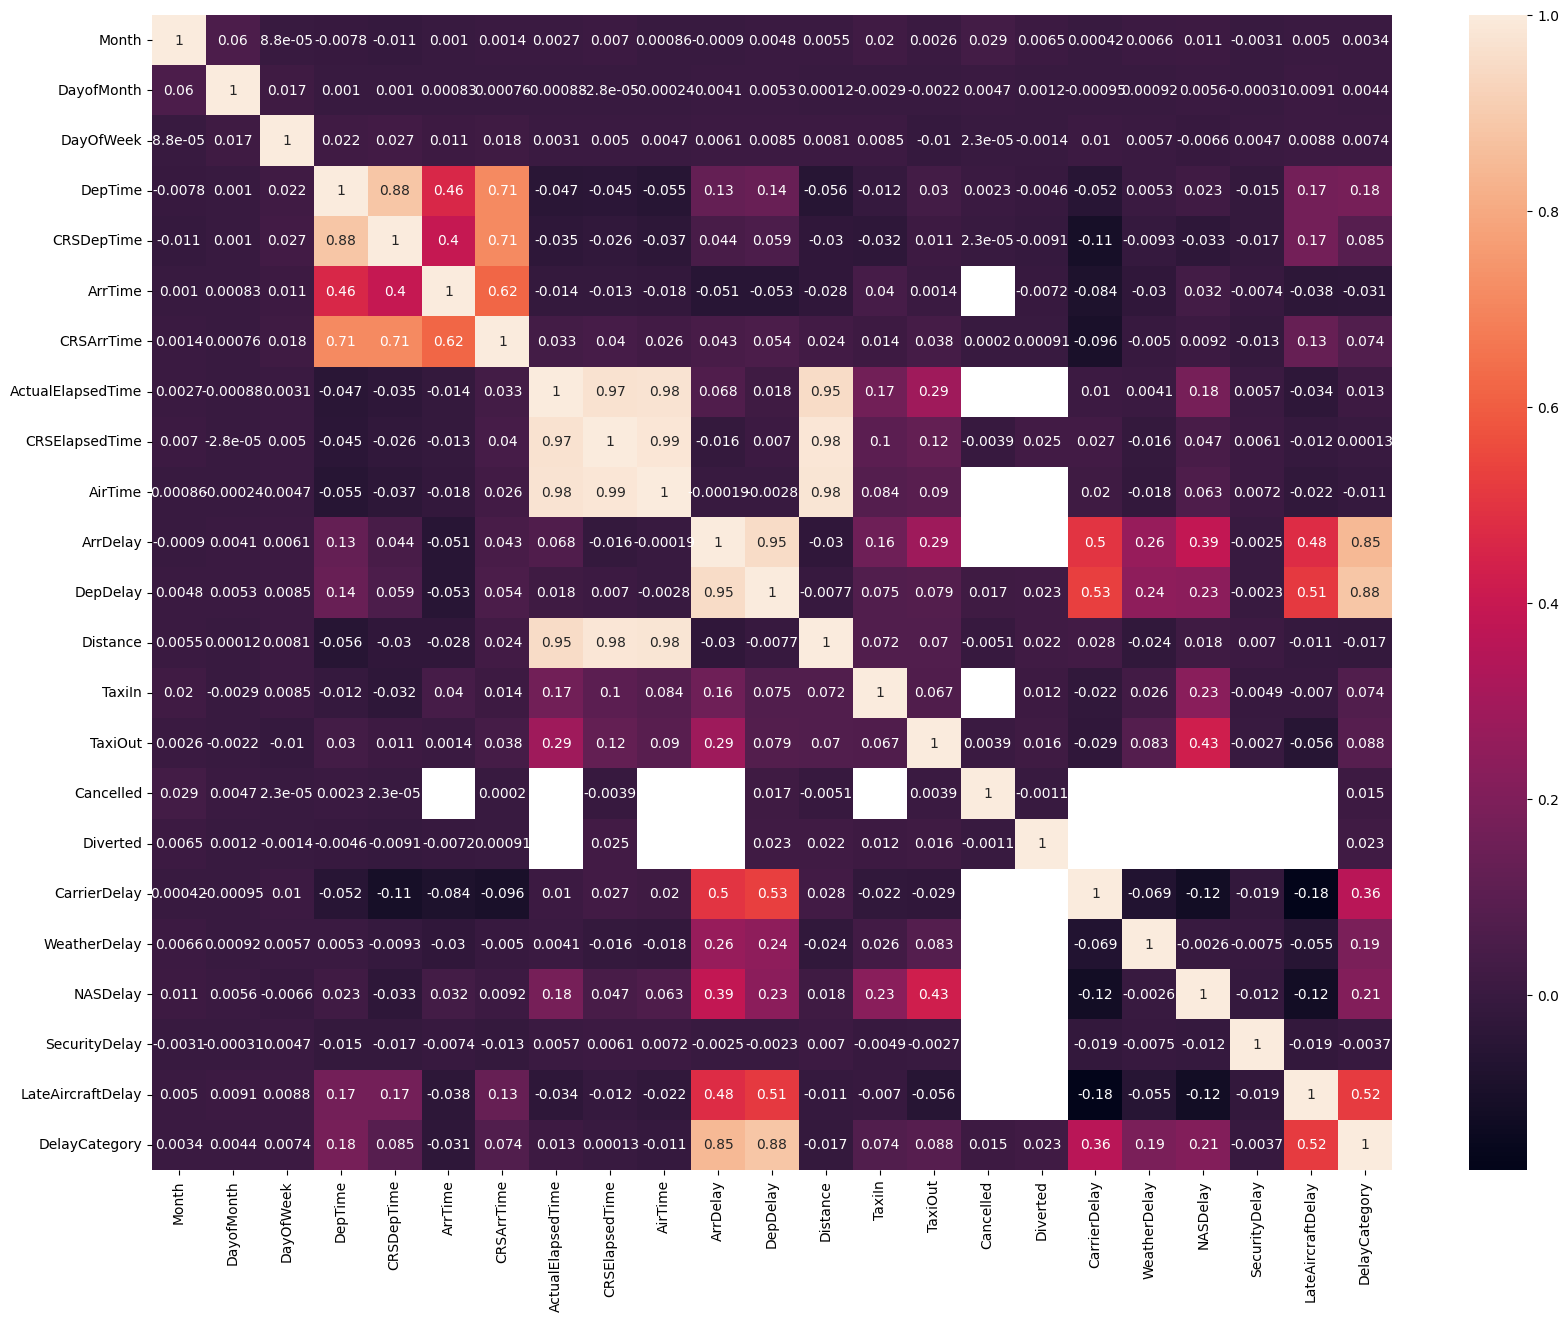

In [10]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(), annot=True, annot_kws={'size': 10})

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936758 entries, 0 to 1936757
Data columns (total 28 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Month              int64  
 1   DayofMonth         int64  
 2   DayOfWeek          int64  
 3   DepTime            float64
 4   CRSDepTime         int64  
 5   ArrTime            float64
 6   CRSArrTime         int64  
 7   UniqueCarrier      object 
 8   TailNum            object 
 9   ActualElapsedTime  float64
 10  CRSElapsedTime     float64
 11  AirTime            float64
 12  ArrDelay           float64
 13  DepDelay           float64
 14  Origin             object 
 15  Dest               object 
 16  Distance           int64  
 17  TaxiIn             float64
 18  TaxiOut            float64
 19  Cancelled          int64  
 20  CancellationCode   object 
 21  Diverted           int64  
 22  CarrierDelay       float64
 23  WeatherDelay       float64
 24  NASDelay           float64
 25  SecurityDelay     

In [28]:
numeric = list(df.select_dtypes(include=['float64', 'int64']).columns)
categorical = list(df.select_dtypes(include=['object']).columns)
numeric, categorical

(['Month',
  'DayofMonth',
  'DayOfWeek',
  'DepTime',
  'CRSDepTime',
  'ArrTime',
  'CRSArrTime',
  'ActualElapsedTime',
  'CRSElapsedTime',
  'AirTime',
  'ArrDelay',
  'DepDelay',
  'Distance',
  'TaxiIn',
  'TaxiOut',
  'Cancelled',
  'Diverted',
  'CarrierDelay',
  'WeatherDelay',
  'NASDelay',
  'SecurityDelay',
  'LateAircraftDelay',
  'DelayCategory'],
 ['UniqueCarrier', 'TailNum', 'Origin', 'Dest', 'CancellationCode'])

In [32]:
try:
    numeric.remove('DelayCategory')
    numeric.remove('DepDelay')
except:
    ...

In [1]:
df = df.sample(frac = .05)

NameError: name 'df' is not defined

In [33]:
X = df.drop(['DelayCategory', 'DepDelay'], axis = 1)
y = df['DelayCategory']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)

numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preproc = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numeric),
    ('category', categorical_pipeline, categorical),
])

#Setting up a pipeline
pl = Pipeline([
    ('preprocessor', preproc),
    ('model', lgbm.LGBMRegressor(task='predict', boosting_type='gbdt', objective='root_mean_squared_error'))
    ])

pl.fit(X_train, y_train)

#training and testing the model
train_preds = pl.predict(X_train)
test_preds = pl.predict(X_test)
print('Training MSE: ' + str(mean_squared_error(train_preds, y_train)**.5), '\nTesting MSE: ' +
     str(mean_squared_error(test_preds, y_test)**.5))